In [10]:
import numpy as np
from tensorflow import keras
random_seed = 233
np.random.seed()
Network = 'ResNet'

# load and shuffel data

In [11]:
train_segments, train_labels = np.load("train_segments.npy"), np.load("train_labels.npy")
test_segments, test_labels = np.load("test_segments.npy"), np.load("test_labels.npy")

print("Original train size:", train_segments.shape, "test size:", test_segments.shape)


Original train size: (11146, 25) test size: (2736, 25)


# prepare data

In [12]:
from sklearn.model_selection import train_test_split
nb_classes = len(np.unique(test_labels))
batch_size = min(train_segments.shape[0]/10, 16)
    
    
Y_train = keras.utils.to_categorical(train_labels, nb_classes)
Y_test = keras.utils.to_categorical(test_labels, nb_classes)
    
x_train = train_segments.reshape(train_segments.shape + (1,))
x_test = test_segments.reshape(test_segments.shape + (1,))
x_train, x_val, Y_train, Y_val  = train_test_split(x_train, Y_train, test_size=0.20, random_state=1)

print(f"train.shape{x_train.shape},{Y_train.shape}")
print(f"val.shape{x_val.shape},{Y_val.shape}")
print(f"test.shape{x_test.shape},{Y_test.shape}")

train.shape(8916, 25, 1),(8916, 5)
val.shape(2230, 25, 1),(2230, 5)
test.shape(2736, 25, 1),(2736, 5)


# ResNet

In [143]:
def residual_block(input_shape, filters, kernel=[3,3,3], strides=1):
    x = input_shape
    k1,k2,k3 = kernel
    # conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv1D(filters, kernel_size=k1, strides=1, padding='same')(x)
    # conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
     
    conv_y = keras.layers.Conv1D(filters, kernel_size=k2, strides=1, padding='same')(conv_x)
    # conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    # print ('build conv_z')
    # conv_z = keras.layers.Conv1D(filters, kernel_size=k3, strides=1, padding='same')(conv_y)
    # conv_z = keras.layers.BatchNormalization()(conv_z)
   
    shortcut_y = keras.layers.Conv1D(filters, kernel_size=1, strides=1,padding='same')(x)
    # shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
   
        
    y = keras.layers.Add()([shortcut_y, conv_y])
    y = keras.layers.Activation('relu')(y)
    return y

def resnet(input_shape,nb_classes):
    input_tensor = keras.layers.Input(shape=(input_shape))
    x = keras.layers.Conv1D(128,kernel_size=7, strides=1, padding='same')(input_tensor)
    # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('elu')(x)
    
    y = residual_block(x,128)
    # y = keras.layers.Dropout(0.3)(y)
    # y = residual_block2(y,16)
    # y = residual_block2(y,64)
    # y = residual_block2(y,64)
    # y = residual_block(y,128)
    # y = keras.layers.Dropout(0.3)(y)
    
    y = keras.layers.GlobalAveragePooling1D()(y)
    # y = keras.layers.Dense(1000, activation='relu')(y)
    # y = keras.layers.Dropout(0.3)(y)
    y = keras.layers.Flatten()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax')(y)
    model = keras.models.Model(inputs=input_tensor, outputs=out)
    return model



In [144]:

model = resnet(x_train.shape[1:],nb_classes)
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                       decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
                loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

nb_epochs = 1500
batch_size = 16
callbacks = [
# keras.callbacks.ModelCheckpoint(
#     "best_model.keras", save_best_only=True, monitor="val_loss"
# ),
keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, min_lr=1e-6
),
keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]

hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
        verbose=1, callbacks = callbacks,validation_data=(x_val, Y_val))

    
from datetime import datetime
current_time = datetime.now()
formatted_time = current_time.strftime("%m%d_%H%M%S")
import pandas as pd
model.save(f'./{Network}/{formatted_time}/Net.h5')
log = pd.DataFrame(hist.history)
log.to_csv(f'./{Network}/{formatted_time}/Accuracy.csv')

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_192 (Conv1D)             (None, 25, 128)      1024        input_36[0][0]                   
__________________________________________________________________________________________________
activation_191 (Activation)     (None, 25, 128)      0           conv1d_192[0][0]                 
__________________________________________________________________________________________________
conv1d_193 (Conv1D)             (None, 25, 128)      49280       activation_191[0][0]             
___________________________________________________________________________________________

e:\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [96]:
X = x_train
for layer in model.layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

InputLayer output shape:	 (8916, 25, 1)
Conv1D output shape:	 (8916, 25, 128)
Activation output shape:	 (8916, 25, 128)
Conv1D output shape:	 (8916, 25, 128)
Activation output shape:	 (8916, 25, 128)
Conv1D output shape:	 (8916, 25, 128)
Conv1D output shape:	 (8916, 25, 128)
Activation output shape:	 (8916, 25, 128)


ValueError: A merge layer should be called on a list of inputs.

# result

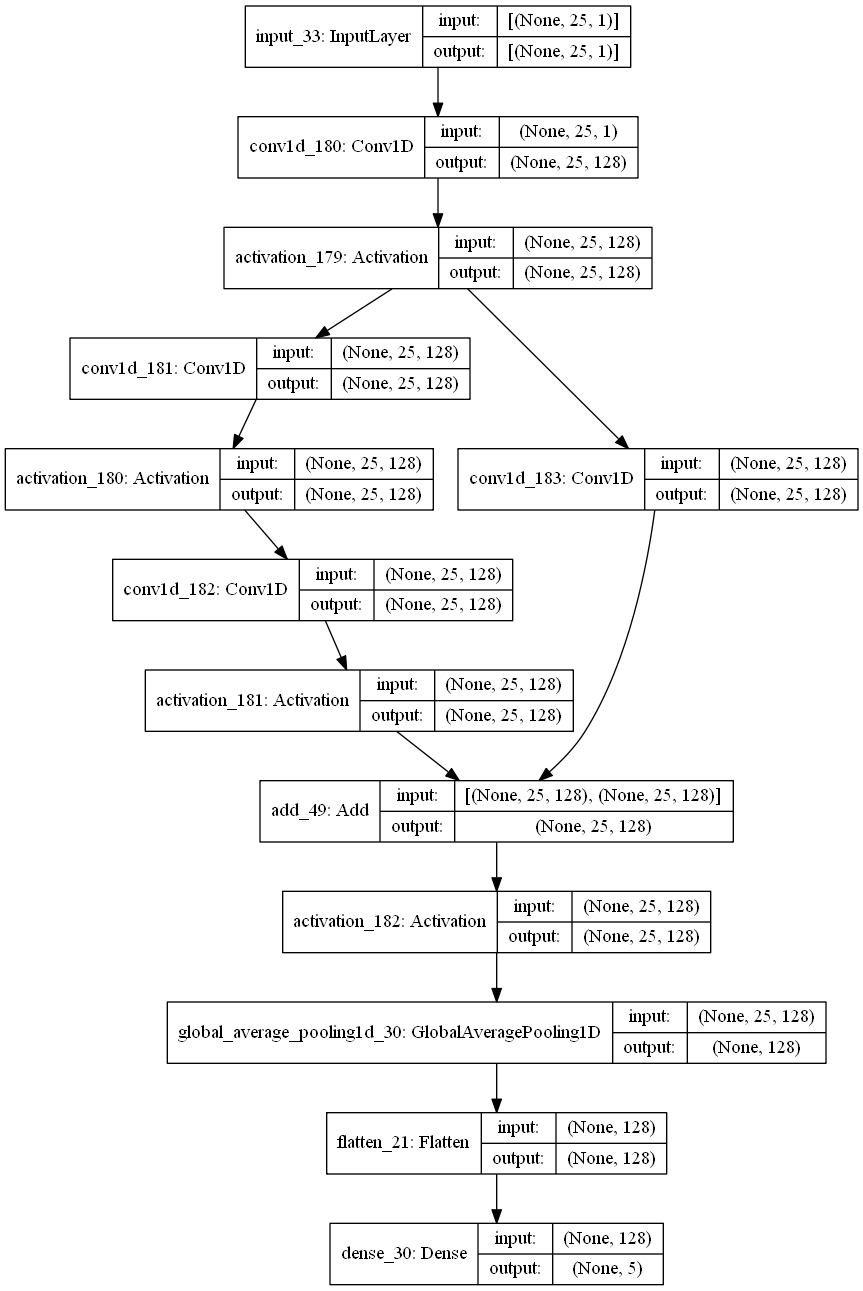

In [134]:
import pydot
from keras.utils.vis_utils import plot_model

plot_model(model,to_file=f"./{Network}/{formatted_time}/model.png",show_shapes=True)

In [145]:
test_loss, test_accuracy = model.evaluate(x_test, Y_test)

86/86 [==============================] - 1s 8ms/step - loss: 0.4006 - accuracy: 0.9097


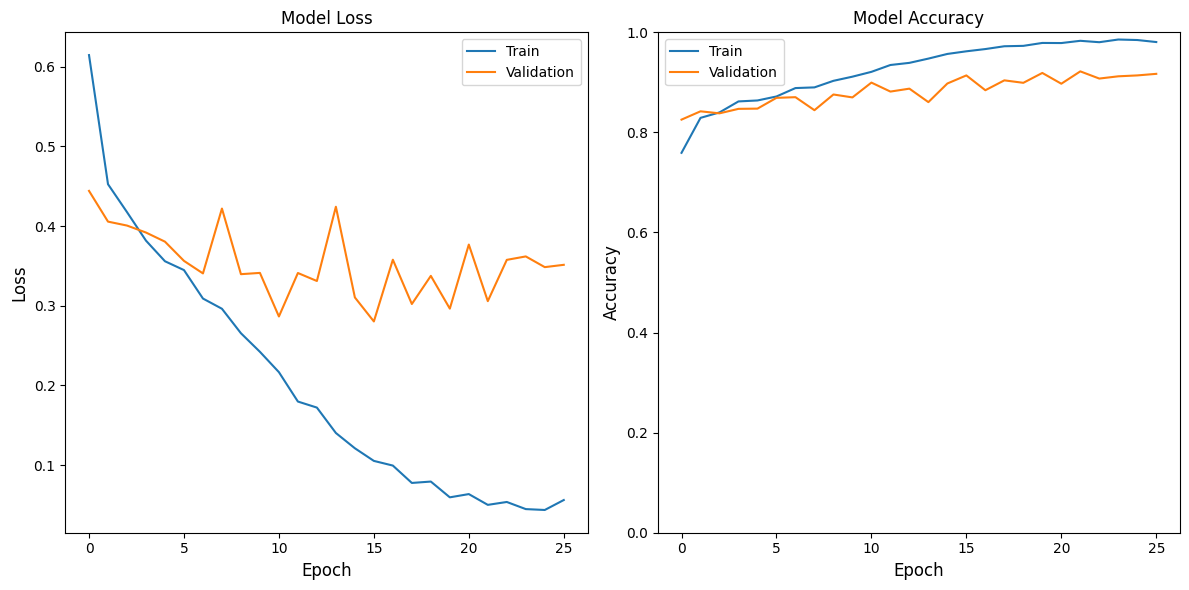

In [147]:
import matplotlib.pyplot as plt

hist = pd.read_csv(f'./{Network}/{formatted_time}/Accuracy.csv')
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Validation"], loc="best")

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Validation"], loc="best")

plt.tight_layout() 

plt.savefig(f'./{Network}/{formatted_time}/Accuracy.png')

# plot confusion matrix

In [140]:
from sklearn import metrics
def plot_confusionMatrix(cM, labels,title=Network):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:}'.format(cmNormalized[predicted,real]),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig( f'./{Network}/{formatted_time}/ConfusionMatrix.png')
def evaluate_model(groundTruthClass,predictedClass):
    accuracy = metrics.accuracy_score(groundTruthClass,predictedClass)
    print('Accuracy:',accuracy*100,'%')
    precision = metrics.precision_score(groundTruthClass,predictedClass,average='macro')
    print('Precision:',precision*100,'%')
    recall = metrics.recall_score(groundTruthClass,predictedClass,average='macro')
    print('Recall:',recall*100,'%')
    f1 = metrics.f1_score(groundTruthClass,predictedClass,average='macro')
    print('F1 score:',f1*100,'%')

86/86 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       542
         1.0       0.82      0.87      0.84       565
         2.0       0.92      0.90      0.91       561
         3.0       0.91      0.90      0.90       524
         4.0       0.96      0.90      0.93       544

    accuracy                           0.91      2736
   macro avg       0.91      0.91      0.91      2736
weighted avg       0.91      0.91      0.91      2736

[[535   7   0   0   0]
 [ 18 489  22  29   7]
 [  4  32 507   7  11]
 [  3  44   3 471   3]
 [  0  26  21  10 487]]
Accuracy for each class is given below.
Sitting     : 98.71 %
Stretching  : 86.55 %
Walking     : 90.37 %
Jumping     : 89.89 %
Running     : 89.52 %


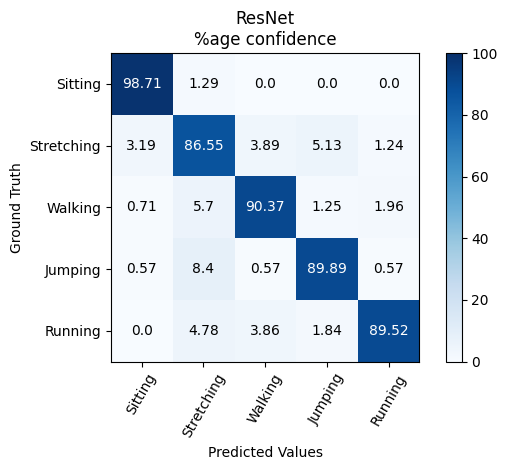

In [148]:
# defining the class labels
labels = [ 'Sitting', 'Stretching', 'Walking', 'Jumping', 'Running']
# predicting the classes
predictions = model.predict(x_test,verbose=1)
# getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((predictions.shape[0]))
groundTruthClass = np.zeros((Y_test.shape[0]))
for instance in range (Y_test.shape[0]):
    predictedClass[instance] = np.argmax(predictions[instance])
    groundTruthClass[instance] = np.argmax(Y_test[instance])
# obtaining a confusion matrix  
clr = metrics.classification_report(groundTruthClass,predictedClass)
print(clr)
cm = metrics.confusion_matrix(groundTruthClass,predictedClass)
print(cm)
# plotting the confusion matrix
plot_confusionMatrix(cm, labels)